In [1]:
import numpy as np
import pandas as pd
import statistics as s
import requests
from bs4 import BeautifulSoup
import json


In [2]:
base_url =  'https://understat.com/league'
leagues = ['La_liga', 'EPL', 'Bundesliga', 'Serie_A', 'Ligue_1', 'RFPL']
seasons = ['2014','2015','2016','2017','2018']

In [3]:
pd.options.mode.chained_assignment = None

def compareresults(df):
    """THIS FUNCTION COMPARES THE ACTUAL MATCH-UP RESULT AND THE EXPECTED RESULT
    IT TAKES A DATAFRAME AS A PARAMETER
    """
    df_withoutdraws = df[df['result']!='d']
    df_withoutdraws.reset_index(inplace=True,drop=True)
    df_withoutdraws['xresult'] = (df_withoutdraws['xG']) > (df_withoutdraws['xGA'])
    df_withoutdraws.replace({'xresult': {True: 'w', False:'l'}},inplace = True)
    df_withoutdraws['isequal'] = (df_withoutdraws['xresult']) == (df_withoutdraws['result'])
    result = (df_withoutdraws['isequal'].sum())/(df_withoutdraws['isequal'].count())
    return result

In [4]:
full_data = dict()
for league in leagues:
    season_data = dict()
    for season in seasons:
        
        url = base_url + '/' + league + '/' + season
        rqst = requests.get(url)
        html_doc = rqst.text
        soup = BeautifulSoup(html_doc)
        # we see that data is in under the <script> tag

        scripts = soup.find_all('script')

        string_with_json_obj = ''

        # finding data for teams
        # teamsdata is under the script tag

        for el in scripts:
            if 'teamsData' in el.text:
                string_with_json_obj = el.text.strip()
        #print(string_with_json_obj)

        # strip unnecessary symbols and get only json data

        start_ind = string_with_json_obj.index("('") + 2
        end_ind = string_with_json_obj.index("')")
        json_data = string_with_json_obj[start_ind:end_ind]
        json_data = json_data.encode('utf8').decode('unicode_escape') # converting the data into readable format

        json_data = json.loads(json_data) # converting string data to python dictionary data

        # get teams and their relevant ids  and put them into separate dictionary

        teams = {}

        for id in json_data.keys():
            teams[id] = json_data[id]['title'] # to see what the title includes

        #EDA to get a feeling how the json_data is structured

        columns = []
        values = []

        for id in json_data.keys():
            columns = json_data[id]['history'][0].keys() 
            values = json_data[id]['history'][0].values()
            break


        #getting data for all the teams

        dataframes = {}

        for id,team in teams.items():
            teams_data = []

            for row in json_data[id]['history']:
                teams_data.append(list(row.values()))



            df = pd.DataFrame(teams_data , columns = columns)
            dataframes[team] = df
            #print('Added data for {}'.format(team))

        #turning ppda and oppda to coefficient like in the website
        for team, df in dataframes.items():

            dataframes[team]['ppda_coef'] = dataframes[team]['ppda'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)
            dataframes[team]['oppda_coef'] = dataframes[team]['ppda_allowed'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)

        cols_to_sum = ['xG','xGA','npxG','npxGA','deep','deep_allowed','scored','missed','xpts','wins','draws','loses','pts','npxGD']
        cols_to_mean = ['ppda_coef','oppda_coef']


        #adding al the dataframes into frames list

        frames = []

        for team,df in dataframes.items():
            sum_data = pd.DataFrame(df[cols_to_sum].sum()).transpose()
            mean_data = pd.DataFrame(df[cols_to_mean].mean()).transpose()
            final_df = sum_data.join(mean_data)
            final_df['team'] = team
            final_df['matches'] = len(df)
            final_df['wins@home'] = dataframes[team][dataframes[team]['h_a']=='h']['wins'].sum()
            final_df['wins@away'] = dataframes[team][dataframes[team]['h_a']=='a']['wins'].sum()
            final_df['scored@home'] = dataframes[team][dataframes[team]['h_a']=='h']['scored'].sum()
            final_df['scored@away'] = dataframes[team][dataframes[team]['h_a']=='a']['scored'].sum()
            final_df['CResult'] = compareresults(df)
            frames.append(final_df)


        full_stat = pd.concat(frames,ignore_index = True) # ignore_index = True otherwise all the indexes can be seen as 0
        #ordering the columns
        full_stat = full_stat[['team','CResult','matches','wins','wins@home','wins@away','draws','loses','scored','scored@home','scored@away','missed','pts','xG','npxG','xGA','npxGA','npxGD','ppda_coef','oppda_coef','deep','deep_allowed','xpts']]
        #sorting the columns by points(pts)
        full_stat.sort_values('pts',ascending=False,inplace = True)

        full_stat.reset_index(inplace = True, drop=True) 

        full_stat['rank'] = range(1,len(full_stat)+1) # cuz it has already sorted by pts, we just making a rank column to show the ranking of the teams

        full_stat['xG_diff'] = full_stat['xG'] - full_stat['scored'] # to see difference between expected goal and actual goal
        full_stat['xGA_diff'] = full_stat['xGA'] - full_stat['missed'] # to see difference between expected missed and actual missed
        full_stat['xpts_diff'] = full_stat['xpts'] - full_stat['pts'] # to see difference between expected points and actual points

        cols_to_int = ['wins','draws','loses','scored','missed','pts','deep','deep_allowed']

        col_order = ['rank','team','CResult','matches','wins','wins@home','wins@away','draws','loses','scored','scored@home','scored@away','missed', 'pts', 'xG', 'xG_diff', 'npxG', 'xGA', 'xGA_diff', 'npxGA', 'npxGD', 'ppda_coef', 'oppda_coef', 'deep', 'deep_allowed', 'xpts', 'xpts_diff']

        full_stat = full_stat[col_order]

        season_data[season] = full_stat
        
    df_season = pd.concat(season_data)
    full_data[league] = df_season

pd.options.display.float_format = '{:,.2f}'.format # to show 2 digits float
data = pd.concat(full_data)
    

In [5]:
data

rank                 team  CResult  matches  wins  \
Bundesliga 2014 0      1        Bayern Munich     0.83       34 25.00   
                1      2            Wolfsburg     0.84       34 20.00   
                2      3  Borussia M.Gladbach     0.80       34 19.00   
                3      4     Bayer Leverkusen     0.83       34 17.00   
                4      5             Augsburg     0.87       34 15.00   
                5      6           Schalke 04     0.76       34 13.00   
                6      7    Borussia Dortmund     0.85       34 13.00   
                7      8           Hoffenheim     0.85       34 12.00   
                8      9        Werder Bremen     0.88       34 11.00   
                9     10  Eintracht Frankfurt     0.92       34 11.00   
                10    11           FC Cologne     0.76       34  9.00   
                11    12             Mainz 05     0.81       34  9.00   
                12    13          Hannover 96     0.71       34  9.00   
                13    14        VfB Stuttgart     0.76       34  9.00   
                14    15         Hamburger SV     0.88       34  9.00   
                15    16        Hertha Berlin     0.81       34  9.00   
                16    17             Freiburg     0.81       34  7.00   
                17    18            Paderborn     0.88       34  7.00   
           2015 0      1        Bayern Munich     0.87       34 28.00   
                1      2    Borussia Dortmund     0.93       34 24.00   
                2      3     Bayer Leverkusen     0.86       34 18.00   
                3      4  Borussia M.Gladbach     0.70       34 17.00   
                4      5           Schalke 04     0.70       34 15.00   
                5      6             Mainz 05     0.85       34 14.00   
                6      7        Hertha Berlin     0.81       34 14.00   
                7      8            Wolfsburg     0.84       34 12.00   
                8      9           FC Cologne     0.71       34 10.00   
                9     10         Hamburger SV     0.73       34 11.00   
                10    11           Ingolstadt     0.92       34 10.00   
                11    12            Darmstadt     0.78       34  9.00   
...                  ...                  ...      ...      ...   ...   
Serie_A    2017 10    11             Sassuolo     0.79       38 11.00   
                11    12                Genoa     0.63       38 11.00   
                12    13              Udinese     0.71       38 12.00   
                13    14               Chievo     0.75       38 10.00   
                14    15              Bologna     0.78       38 11.00   
                15    16             Cagliari     0.75       38 11.00   
                16    17            SPAL 2013     0.92       38  8.00   
                17    18              Crotone     0.77       38  9.00   
                18    19               Verona     0.82       38  7.00   
                19    20            Benevento     0.83       38  6.00   
           2018 0      1             Juventus     0.88       38 28.00   
                1      2               Napoli     0.81       38 24.00   
                2      3             Atalanta     0.72       38 20.00   
                3      4                Inter     0.79       38 20.00   
                4      5             AC Milan     0.85       38 19.00   
                5      6                 Roma     0.81       38 18.00   
                6      7               Torino     0.70       38 16.00   
                7      8                Lazio     0.87       38 17.00   
                8      9            Sampdoria     0.87       38 15.00   
                9     10              Bologna     0.70       38 11.00   
                10    11             Sassuolo     1.00       38  9.00   
                11    12              Udinese     0.82       38 11.00   
                12    13            SPAL 2013     0.76       38 11.00   
     

In [6]:
### Mean of the CResults by season for each league
cresults_dict = {}
season_dict = {}

for league in leagues:
    
    for season in seasons:
        
        singlemean = data.loc[league].loc[season]['CResult'].mean()
        season_dict[season] = singlemean
        
    cresults_dict[league] = dict(season_dict)

#cresults_dict

In [7]:
df_cresult = pd.DataFrame(cresults_dict)
df_cresult

,La_liga,EPL,Bundesliga,Serie_A,Ligue_1,RFPL
2014,0.80,0.77,0.82,0.83,0.80,0.84
2015,0.85,0.79,0.79,0.78,0.79,0.81
2016,0.83,0.82,0.81,0.83,0.79,0.79
2017,0.80,0.80,0.79,0.80,0.75,0.81
2018,0.80,0.80,0.78,0.78,0.78,0.82


In [8]:
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

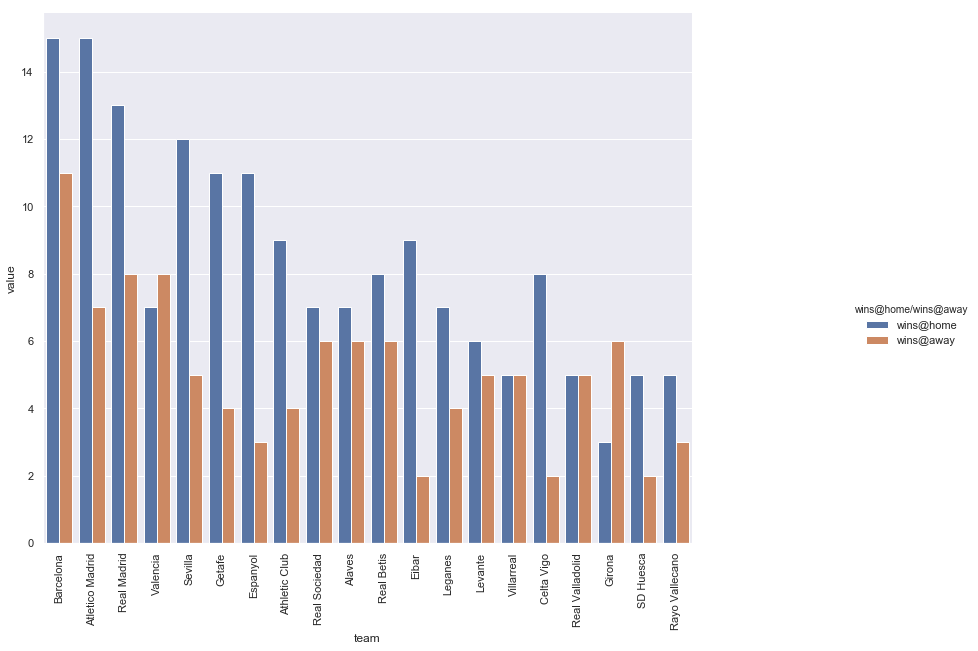

In [9]:
#columns_needed = ['rank','team','matches','wins','wins@home','wins@away','draws','loses','scored','scored@home','scored@away']
columns_needed = ['team','wins@home','wins@away']
df_clean = data.loc['La_liga'].loc['2018'][columns_needed]
df_melt = pd.melt(df_clean, id_vars = ['team'],value_vars = ['wins@home','wins@away'],var_name = 'wins@home/wins@away')
#print(df_melt)
sns.set()
sns.catplot(x='team',y='value',hue='wins@home/wins@away',data=df_melt,kind='bar',legend=True)
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(15,9) ### to illustrate of a comparision between wins at home and wins at away for La Liga season 2018
### the graph shows that most of the teams at La Liga wins more matches at home than the matches at away

In [10]:
def calwinrate(df,season):
    """CALCULATES THE WIN RATIO BETWEEN WINS@HOME AND WINS@AWAY
    TAKES TWO PAREMETERS df= df of league, season = seasons """
    
    values = []
    for i in season:
        df[i]['H>A'] = (df[i]['wins@home']) > (df[i]['wins@away'])
        num1 = df[i]['H>A'].sum()
        num2 = df[i]['H>A'].count()
        value = num1/num2
        values.append(value)
    return values


In [11]:
df_EPL = {}
for season in seasons:
    df_EPL[season] = data.loc['EPL'].loc[season][['team','wins@home','wins@away']]

df_La_liga = {}
for season in seasons:
    df_La_liga[season] = data.loc['La_liga'].loc[season][['team','wins@home','wins@away']]
    
    
df_RFPL = {}
for season in seasons:
    df_RFPL[season] = data.loc['RFPL'].loc[season][['team','wins@home','wins@away']]
    
    
df_Serie_A= {}
for season in seasons:
    df_Serie_A[season] = data.loc['Serie_A'].loc[season][['team','wins@home','wins@away']]
    
    
df_Ligue_1= {}
for season in seasons:
    df_Ligue_1[season] = data.loc['Ligue_1'].loc[season][['team','wins@home','wins@away']]

df_Bundesliga = {}
for season in seasons:
    df_Bundesliga[season] = data.loc['Bundesliga'].loc[season][['team','wins@home','wins@away']]

In [15]:
winrates = {}
seasons = ['2014','2015','2016','2017','2018']
leagues = ['La_liga', 'EPL', 'Bundesliga', 'Serie_A', 'Ligue_1', 'RFPL']
leagueslist = [df_La_liga,df_EPL,df_Bundesliga,df_Serie_A,df_Ligue_1,df_RFPL]
i = 0
for df in leagueslist:
    winrates[leagues[i]] = calwinrate(df,seasons)
    i = i+1
    
    
#Bundesliga_winrate = calwinrate(df_Bundesliga,seasons)
print(winrates)

{'La_liga': [0.9, 0.95, 0.85, 1.0, 0.8], 'EPL': [0.9, 0.8, 0.75, 0.85, 0.95], 'Bundesliga': [0.9444444444444444, 0.7222222222222222, 0.8333333333333334, 0.8888888888888888, 0.8333333333333334], 'Serie_A': [0.8, 0.85, 0.9, 0.7, 0.75], 'Ligue_1': [0.85, 0.75, 0.95, 0.85, 0.85], 'RFPL': [0.6875, 0.75, 0.6875, 0.625, 0.75]}


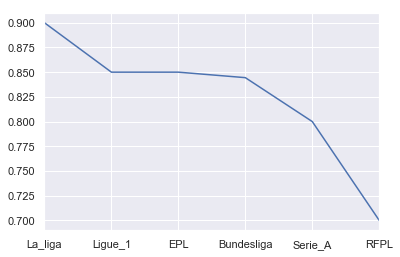

In [25]:
df_winrates = pd.DataFrame(winrates,index=seasons)
df_winrates
df_winrates.mean().sort_values(ascending=False).plot()
### This graph shows that Europe is more passionate about Footbal than Russia

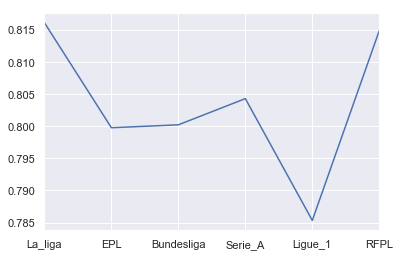

In [28]:
#f,(ax1,ax2) = plt.subplots(2,1,figsize=(7,5),sharex=True)
sns.set()
df_cresult.mean().plot()